### train

#### imports and constants

In [1]:
import pandas as pd
import torch
import numpy as np

In [2]:
data_path = "data/toxic/toxic"

#### read data

In [3]:
df_train = pd.read_csv(data_path+"_train_clean.csv")
df_test = pd.read_csv(data_path+"_test_clean.csv")

In [4]:
df_train.head()

,content,label
0,explanation why the edits made under my userna...,0
1,d'aww ! he matches this background colour i'm ...,0
2,"hey man , i'm really not trying to edit war . ...",0
3,""" more i can't make any real suggestions on im...",0
4,"you , sir , are my hero . any chance you remem...",0


In [5]:
# Get the lists of sentences and their labels.
sentences_train = df_train.content.values
labels_train = df_train.label.values

sentences_test = df_test.content.values
labels_test = df_test.label.values

#### tokenising & formatting data

In [2]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

I0601 12:32:36.373601 140251914221312 file_utils.py:39] PyTorch version 1.1.0 available.
W0601 12:32:36.987436 140251914221312 __init__.py:28] To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html
I0601 12:32:37.422487 140251914221312 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


Loading BERT tokenizer...


I0601 12:32:38.329735 140251914221312 tokenization_utils.py:374] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/gallil/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [7]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []

# For every sentence in train
for sent in sentences_train:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids_train.append(encoded_sent)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []

# For every sentence in test
for sent in sentences_test:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids_test.append(encoded_sent)

W0519 14:46:48.197519 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors
W0519 14:46:49.220181 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
W0519 14:47:01.571424 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (3731 > 512). Running this sequence through the model will result in indexing errors
W0519 14:47:05.309104 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors
W0519 14:47

W0519 14:48:18.213428 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (888 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48:18.919392 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1135 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48:19.110232 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48:19.529820 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48

W0519 14:48:34.484004 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48:34.495610 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (908 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48:34.643521 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48:34.874678 140148923213568 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
W0519 14:48

In [8]:
def pad_sequences(input_ids, maxlen):
    padded = []
    for inp in input_ids:
        if len(inp) >= maxlen:
            padded.append(inp[:maxlen-1] + [inp[-1]])
        else:
            padded.append(inp + [0]*(maxlen - len(inp)))
    return padded

#### histogram of length for choosing the length

In [9]:
import matplotlib.pyplot as plt

I0519 14:48:41.153230 140148923213568 font_manager.py:1349] generated new fontManager


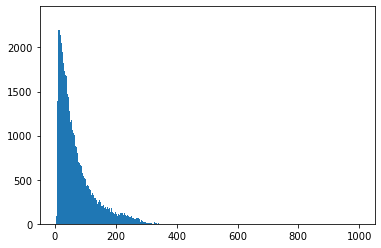

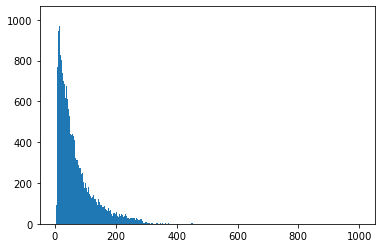

In [10]:
lens_train = [len(inp) for inp in  input_ids_train]
plt.hist(lens_train, bins=1000, range=(0,1000))
plt.show()
lens_test = [len(inp) for inp in  input_ids_test]
plt.hist(lens_test, bins=1000, range=(0,1000))
plt.show()

In [11]:
print((np.array(lens_test)<=128).sum()) # / len(lens_train))

51861


In [12]:
# Set the maximum sequence length.
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN)

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


In [13]:
# Create attention masks
attention_masks_train = []

# For each sentence...
for sent in input_ids_train:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_train.append(att_mask)
    
# Create attention masks
attention_masks_test = []

# For each sentence...
for sent in input_ids_test:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_test.append(att_mask)

In [14]:
# rename
train_inputs, validation_inputs, train_labels, validation_labels = input_ids_train, input_ids_test, labels_train, labels_test 
train_masks, validation_masks = attention_masks_train, attention_masks_test

### create dataset & dataloader

In [15]:
# Convert all inputs and labels into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [17]:
train_inputs.element_size(), train_inputs.nelement()

(8, 19300864)

In [18]:
train_inputs.shape

torch.Size([150788, 128])

### model & optimiser & scheduler

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

I0519 14:48:49.317243 140148923213568 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/gallil/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0519 14:48:49.320569 140148923213568 configuration_utils.py:168] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "torchscript": false,


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_aff

In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [21]:
from transformers import WarmupLinearSchedule

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = WarmupLinearSchedule(optimizer, 
                                 warmup_steps = 0, # Default value in run_glue.py
                                 t_total = total_steps)

### train loop

In [22]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return (pred_flat == labels_flat).mean()

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
# evaluation only - to make sure that accuracy is more or less random at the beginnig
print("")
print("Running Validation...")
device = "cuda"
t0 = time.time()

model.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():        
        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))



Running Validation...
  Accuracy: 0.86
  Validation took: 0:03:25


In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42
device = "cuda:0"
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print()
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull theloss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 - This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        

            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  4,713.    Elapsed: 0:00:14.
  Batch    80  of  4,713.    Elapsed: 0:00:27.
  Batch   120  of  4,713.    Elapsed: 0:00:40.
  Batch   160  of  4,713.    Elapsed: 0:00:54.
  Batch   200  of  4,713.    Elapsed: 0:01:07.
  Batch   240  of  4,713.    Elapsed: 0:01:21.
  Batch   280  of  4,713.    Elapsed: 0:01:34.
  Batch   320  of  4,713.    Elapsed: 0:01:49.
  Batch   360  of  4,713.    Elapsed: 0:02:03.
  Batch   400  of  4,713.    Elapsed: 0:02:18.
  Batch   440  of  4,713.    Elapsed: 0:02:33.
  Batch   480  of  4,713.    Elapsed: 0:02:47.
  Batch   520  of  4,713.    Elapsed: 0:03:01.
  Batch   560  of  4,713.    Elapsed: 0:03:16.
  Batch   600  of  4,713.    Elapsed: 0:03:30.
  Batch   640  of  4,713.    Elapsed: 0:03:44.
  Batch   680  of  4,713.    Elapsed: 0:03:58.
  Batch   720  of  4,713.    Elapsed: 0:04:13.
  Batch   760  of  4,713.    Elapsed: 0:04:27.
  Batch   800  of  4,713.    Elapsed: 0:04:42.
  Batch   840  of

### saving

In [26]:
torch.save(model.state_dict(), open(data_path+"e2e_bert.pth", 'wb'))

### inference example

In [28]:
# with a saved model & cpu - Load a trained model that you have fine-tuned
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased", state_dict=torch.load(data_path+"e2e_bert.pth"))

I0319 10:08:26.287150 140144781510400 tokenization_utils.py:374] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/gallil/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0319 10:08:27.398584 140144781510400 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/gallil/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
I0319 10:08:27.402496 140144781510400 configuration_utils.py:168] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
 

In [29]:
# %%timeit
text = 'it was tedious at times but altogether i would recommend it'
model_loaded.eval()
with torch.no_grad():
    sent_token = torch.Tensor(pad_sequences([tokenizer.encode(text, add_special_tokens=True)], 128)).long()
    sent_att = (sent_token > 0).int()
    res = model_loaded(sent_token, attention_mask=sent_att)

## infer on test

In [32]:
base_path = 'data/toxic/toxic'
model_path = base_path + 'e2e_bert.pth'
tst_path = base_path + '_test_clean.csv'
out_path = base_path + '_test_pred.csv'

In [33]:
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased", state_dict=torch.load(model_path))
model_loaded.cuda()

I0519 14:55:26.958632 140148923213568 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/gallil/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0519 14:55:26.962064 140148923213568 configuration_utils.py:168] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "torchscript": false,


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_aff

In [34]:
# rad the dataset
tst_df = pd.read_csv(tst_path)

In [35]:
import torch.nn.functional as F

In [36]:
import time
import datetime

In [37]:
pred_list = []
proba_list = []
# evaluation only
print("")
print("Running Validation...")
device = "cuda"
t0 = time.time()

model_loaded.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():        
        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model_loaded(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the "logits" output by the model
    logits = outputs[0]
    
    probs, preds = F.softmax(logits).max(1)
    
    pred_list.append(preds.cpu().numpy())
    proba_list.append(probs.cpu().numpy())
    
tst_df['preds'] = np.concatenate(pred_list)


Running Validation...


/storage/conda_envs/left/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


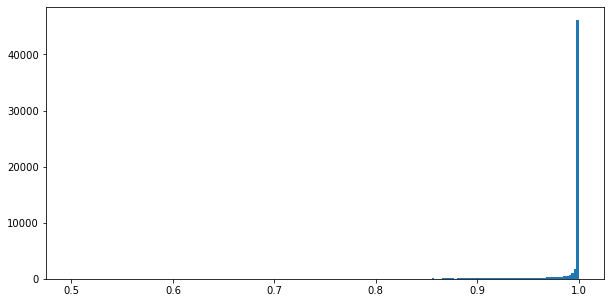

In [38]:
import matplotlib.pyplot as plt
# look at distibution of probabilities
plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(proba_list), bins=200)
plt.show()

In [39]:
# make sure of accuracy and no mistakes
(tst_df['preds']==tst_df['label']).sum()/len(tst_df)

0.9144682537062105

In [34]:
# save result
tst_df.to_csv(out_path, index=False)